# Volumetric Registration
In this tutorial we align a mouse brain to the Allen Referece Atlas (ARA).  Thus the ARA is our _reference_ image, it consists of image data stored in the default "average" channel and corresponding annotations stored in a separate "annotation" channel.  We begin by importing the relevant modules

In [2]:
%matplotlib inline

In [3]:
from ndreg import *
import matplotlib
#import ndio.remote.neurodata as neurodata
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
from requests import HTTPError
import time
import configparser
startTime = time.time()

We define the server and our user token

In [4]:
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [6]:
# Assume a valid configuration file exists at ~/.intern/intern.cfg.
cfg_file = '/run/data/.intern/intern.cfg'
if cfg_file.startswith('~'): 
    cfg_file = os.path.expanduser('~') + cfg_file[1:]
config = configparser.ConfigParser()
config.read_file(file(cfg_file))
TOKEN = config['Default']['token']
rmt = BossRemote(cfg_file_or_dict=cfg_file)

First we'll download the atlas image

In [7]:
REFERENCE_COLLECTION = 'ara_2016'
REFERENCE_EXPERIMENT = 'sagittal_50um'
REFERENCE_COORDINATE_FRAME = 'ara_2016' 
REFERENCE_CHANNEL = 'average_50um'
# Set/Modify these parameters
REFERENCE_RESOLUTION = 0
REFERENCE_ISOTROPIC = True

In [8]:
(ref_exp_resource, ref_coord_resource, ref_channel_resource) = setup_channel_boss(rmt, REFERENCE_COLLECTION, REFERENCE_EXPERIMENT, REFERENCE_CHANNEL)
refImg = imgDownload_boss(rmt, ref_channel_resource, ref_coord_resource, resolution=REFERENCE_RESOLUTION, isotropic=REFERENCE_ISOTROPIC)  

In [9]:
refThreshold = imgPercentile(refImg, 0.99)

In [10]:
refImg.GetSize()

(264, 160, 228)

In [11]:
refImg.GetSpacing()

(0.05, 0.05, 0.05)

Next we'll visualize the image.  To ensure that the visuization is has good contrast we'll only show intensity values below the 99th percentile.

When given an image volume *imgShow* displays it as a set of evenly spaced z-slices (1st column), y-slices (2nd column) and x slices (3rd column).

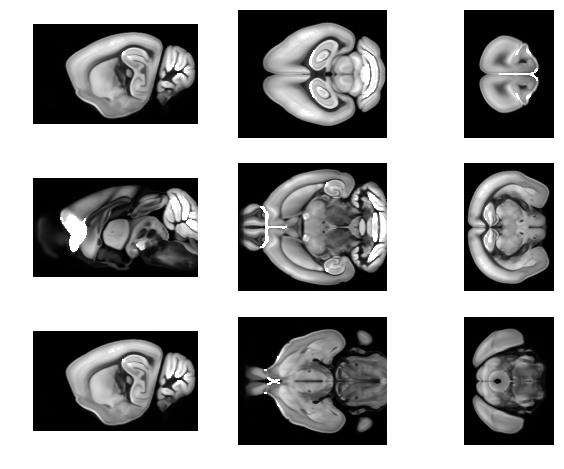

In [12]:
imgShow(refImg, vmax=refThreshold)

Now we download the corresponding annotations

In [13]:
REFERENCE_ANNOTATION_COLLECTION = 'ara_2016'
REFERENCE_ANNOTATION_EXPERIMENT = 'sagittal_50um'
REFERENCE_ANNOTATION_COORDINATE_FRAME = 'ara_2016' 
REFERENCE_ANNOTATION_CHANNEL = 'annotation_50um'
REFERENCE_ANNOTATION_RESOLUTION = REFERENCE_RESOLUTION
REFERENCE_ANNOTATION_ISOTROPIC = True

In [14]:
(refAnnotation_exp_resource, refAnnotation_coord_resource, refAnnotation_channel_resource) = setup_channel_boss(rmt, REFERENCE_ANNOTATION_COLLECTION, REFERENCE_ANNOTATION_EXPERIMENT, REFERENCE_ANNOTATION_CHANNEL)
refAnnotationImg = imgDownload_boss(rmt, refAnnotation_channel_resource, refAnnotation_coord_resource, resolution=REFERENCE_ANNOTATION_RESOLUTION, isotropic=REFERENCE_ANNOTATION_ISOTROPIC)

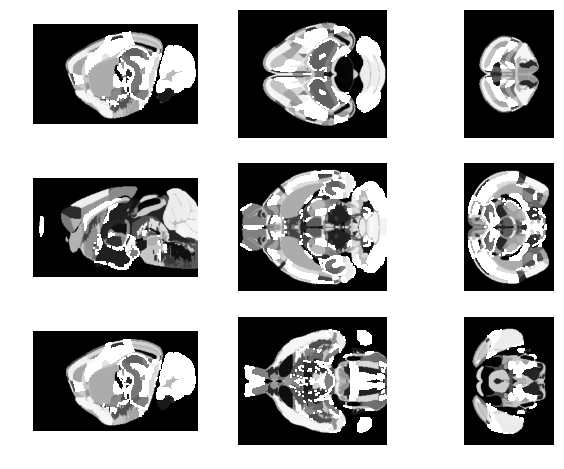

In [15]:
imgShow(refAnnotationImg, vmax=1000)

It's usually better to visuaize a set of annotations in color.  Let's display the atlas annotations using a random colormap.  We begin by creating a 1000x3 array of random values. Since we always want the backgrond (label 0) to be dark we make the 0th row is [0,0,0].

In [16]:
randValues = np.random.rand(1000,3)
randValues = np.concatenate(([[0,0,0]],randValues))

Now we can display the annotations.

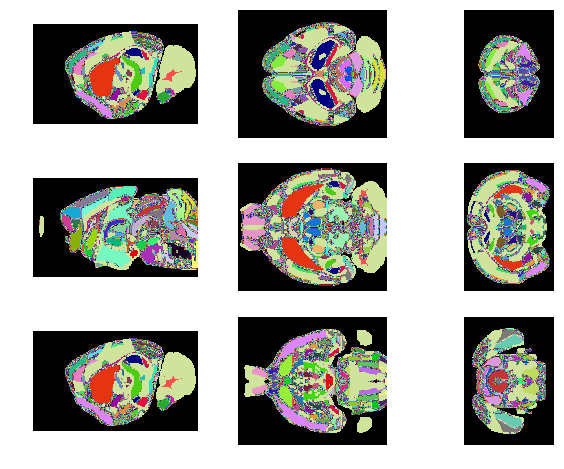

In [17]:
randCmap = matplotlib.colors.ListedColormap(randValues)
imgShow(refAnnotationImg, vmax=1000, cmap=randCmap)

Let's overlay these annotations on the atlas image using alpha transparency.  To do this we must set *newFig* to *False* so that matplotlib appends the annotation data to the current figure instead of creating new one.  

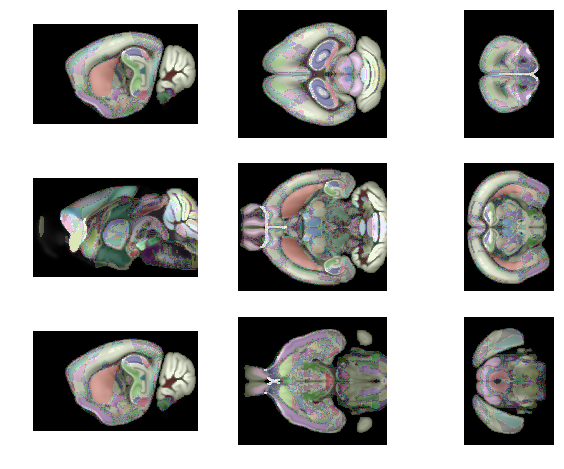

In [18]:
imgShow(refImg, vmax=refThreshold, newFig=False)
imgShow(refAnnotationImg, vmax=1000, cmap=randCmap, alpha=0.3, newFig=False)
plt.show()

# Remove missing parts of brain

In [110]:
remove_regions = [507, 212, 220, 228, 236, 244, 151, 188, 196, 204]

In [111]:
refAnnoImg = sitk.GetArrayFromImage(refAnnotationImg)
remove_indices = np.isin(refAnnoImg, remove_regions)

In [112]:
refAnnoImg[remove_indices] = 0

In [113]:
# adjust annotations
refAnnoImg_adj = sitk.GetImageFromArray(refAnnoImg)
refAnnoImg_adj.SetSpacing(refAnnotationImg.GetSpacing())
refAnnotationImg = refAnnoImg_adj
# adjust atlas with corresponding indices
# refImg_adj = sitk.GetArrayFromImage(refImg)
# refImg_adj[remove_indices] = 0
# refImg_adj = sitk.GetImageFromArray(refImg_adj)
# refImg_adj.SetSpacing(refImg.GetSpacing())
# refImg = refImg_adj

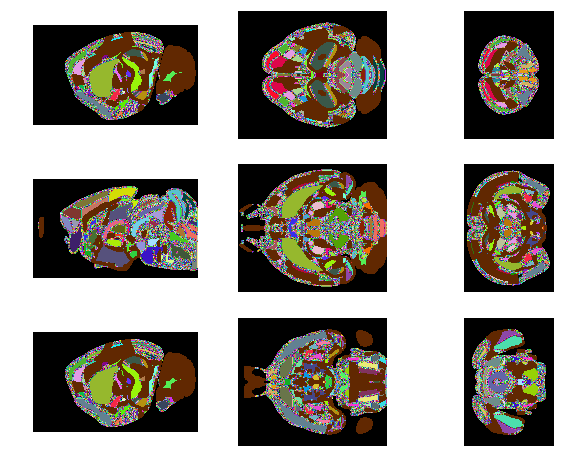

In [114]:
imgShow(refAnnotationImg, vmax=1000, cmap=randCmap, alpha=1, newFig=False)

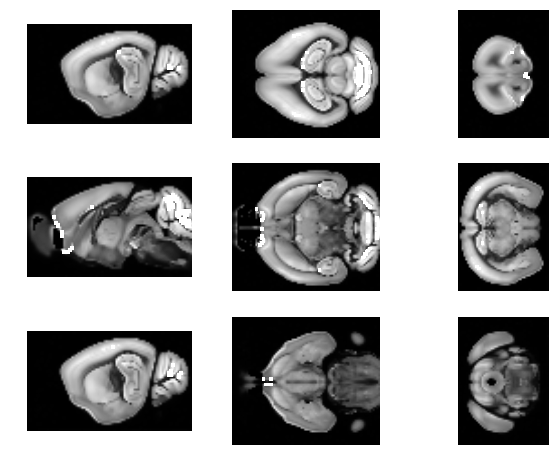

In [30]:
imgShow(refImg, vmax=refThreshold)

# Downloading input image

In [24]:
# Modify these parameters for your specific experiment
SAMPLE_COLLECTION = 'ailey-dev'
SAMPLE_EXPERIMENT = 's3617'
SAMPLE_COORDINATE_FRAME = 'aileydev_s3617'
SAMPLE_CHANNEL = 'channel1'
SAMPLE_RESOLUTION = 4
SAMPLE_ISOTROPIC = False

In [25]:
sample_exp_resource, sample_coord_resource, sample_channel_resource = setup_channel_boss(rmt, SAMPLE_COLLECTION, SAMPLE_EXPERIMENT, SAMPLE_CHANNEL)

In [26]:
sampleImg = imgDownload_boss(rmt, sample_channel_resource, sample_coord_resource, resolution=SAMPLE_RESOLUTION, isotropic=SAMPLE_ISOTROPIC)

KeyboardInterrupt: 

We'll only use intensity values below the 99th percentile in the visualization.

In [ ]:
sampleThreshold = imgPercentile(sampleImg, .999)
imgShow(sampleImg, vmax=sampleThreshold)

In [23]:
sampleImg.GetSize()

(922, 1311, 79)

In [36]:
sampleImg.GetSpacing()

(0.01872, 0.01872, 0.16)

In [122]:
#sitk.WriteImage(sampleImg, SAMPLE_COLLECTION + '_' + SAMPLE_EXPERIMENT + '_' + SAMPLE_CHANNEL + '_' + 'res' + str(SAMPLE_RESOLUTION) + '.tif')

## Reorienting input image
You may have noticed that the input brain is not oriented in the same way as the atlas.  Let's look at the atlas.

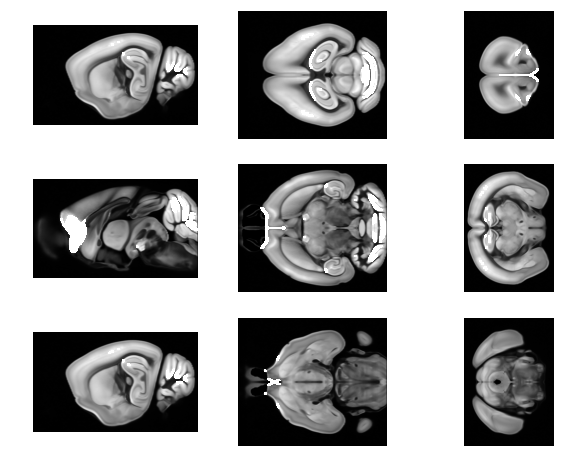

In [146]:
imgShow(refImg, vmax=refThreshold)

By examining the the z slices in the first column its clear that the x-axis goes from **R**ight to Left side of the brain. The y-axis varies from **S**uperior to Inferior and the z-axis goes from **A**nterior to posterior.  Thus it is in **RSA** orientation.  Looking at the the input brain...

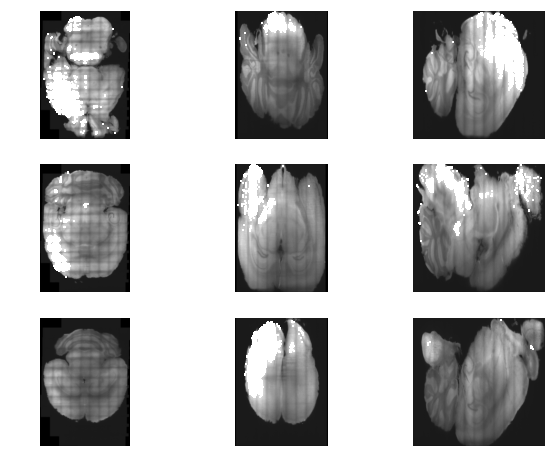

In [147]:
imgShow(sampleImg, vmax=sampleThreshold)

...we see that the x-axis goes from **R**ight to Left, the y-axis goes from **P**osterior to Anterior and the Z axis goes from **I**nferior to Superior.  Thus it's in **RPI** orientation.  Therefore we reorient the input image from **RPI** to **RSA**

Compare the above to the Atlas.  The slices should now correspond with the atlas.  Let's make a copy of the reorianted image size and spacing because we'll need it later.

In [148]:
# modify sampleOrient based on your image orientation
sampleOrient = "RPI"
refOrient = "ASR"

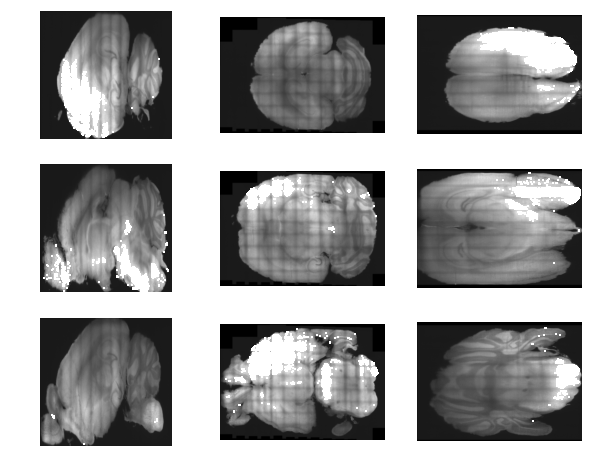

In [149]:
sampleImgReoriented = imgReorient(sampleImg, sampleOrient, refOrient)
imgShow(sampleImgReoriented, vmax=sampleThreshold)

## Downsample images
Now we downsample the input and reference images to a more manageable size

In [156]:
DOWNSAMPLE_SPACING = 0.010 # millimeters
spacing = [DOWNSAMPLE_SPACING,DOWNSAMPLE_SPACING,DOWNSAMPLE_SPACING]

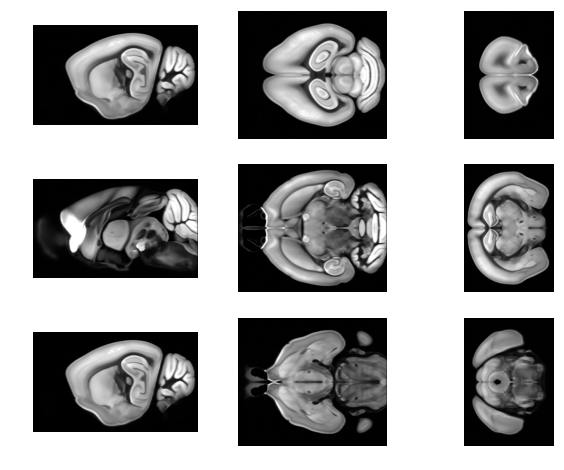

In [166]:
# if spacing == refImg.GetSpacing(): 
#     refImg_ds = sitk.Clamp(refImg, upperBound=refThreshold)
# else:
refImg_ds = sitk.Clamp(imgResample(refImg, spacing), upperBound=refThreshold)
imgShow(refImg_ds)

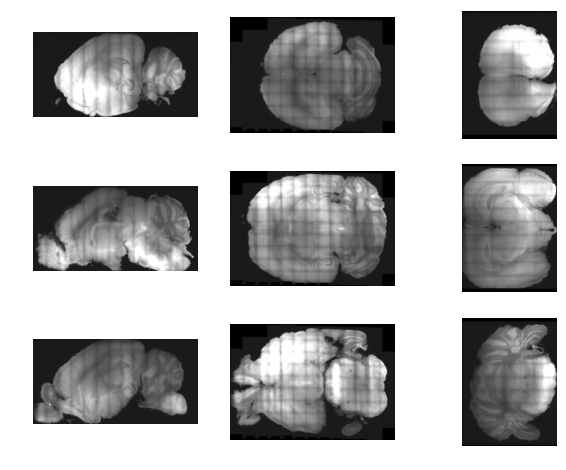

In [167]:
sampleImg_ds = sitk.Clamp(imgResample(sampleImgReoriented, spacing), upperBound=sampleThreshold)
imgShow(sampleImg_ds)

In [168]:
sampleImgSize_reorient = sampleImgReoriented.GetSize()
sampleImgSpacing_reorient= sampleImgReoriented.GetSpacing()

# Affine Registration
Now we compute the affine transform.  Unlike in the [basic registration tutiorial](basicRegistration.ipynb) we'll use the *imgAffineComposite* instead of *imgAffine*.  *imgAffine* simply computes the affine transform between the input and reference images.  *imgAffineComposite* computes a translation then a rigid then an affine transformation.  It's output is the composition of those three transforms.  We use Mutual Information since the input and reference images have very differnt intensity profiles.  We also enable the *verbose* option so that each iteration is printed.

In [ ]:
affine = imgAffineComposite(sampleImg_ds, refImg_ds, iterations=200, useMI=True, verbose=True)

Step translation:
0.	 -0.17878450386
1.	 -0.188644515258
2.	 -0.197649636094
3.	 -0.207277777686
4.	 -0.217873702705
5.	 -0.227502876285
6.	 -0.238703528706
7.	 -0.25157478535


Now we apply the affine transform to the input image and mask

[0.9541681325365168, 0.05835207944758628, 0.018533339701541366, 0.004790034693515006, 0.9445756442232279, -0.006499685213981909, 0.02874263266693851, 0.054653388717895664, 0.8829932089315535, -1.324585647376747, -0.33155805155454415, -1.180287518508166]


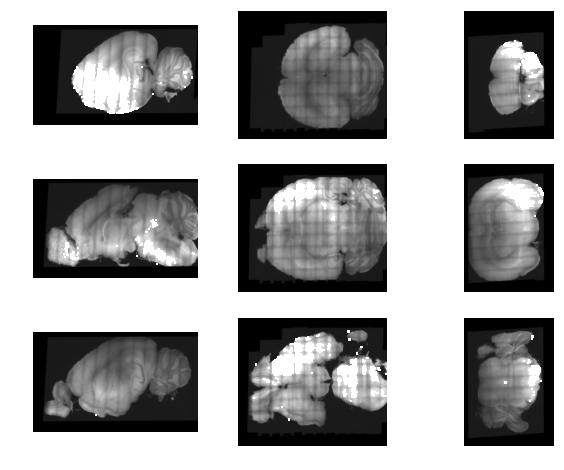

In [34]:
print(affine)
sampleImg_affine = imgApplyAffine(sampleImgReoriented, affine, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(sampleImg_affine, vmax=sampleThreshold)

We can evaluate the affine registration by generating a checkerboard of the reference and input images.  In this method the input image is placed on the black squares of the metaphorical checkerboard while the reference image is placed on the red squares.  Idealy anatomical sturctures should line up across squares.

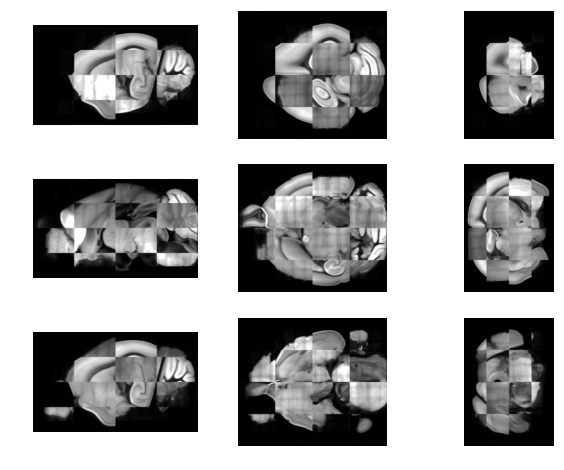

In [35]:
sampleImg_affine_bounded = sitk.Clamp(sampleImg_affine,upperBound=sampleThreshold)
refImg_bounded = sitk.Clamp(refImg, upperBound=refThreshold)
imgShow(imgChecker(sampleImg_affine_bounded, refImg_bounded))

# LDDMM registration
Now we run LDDMM registration. Here we use *imgMetamorphosisComposite*.  Unlike *imgMetamorphosis* introduced in the [2D registration notebook](2D_Registration.ipynb), this function runs LDDMM in multiple steps using the alpha values specified by in *alphaList*. The *field* and *invField* outputs are the composition of all steps.  Once agan we use a Mutual Information cost because the input brain and reference image have very differnt intensity profiles.

In [36]:
(field, invField) = imgMetamorphosisComposite(sampleImg_ds, refImg_ds, alphaList=[0.2, 0.1, 0.05],
                                              scaleList = 1.0, useMI=True, iterations=100, verbose=True)


Step 0: alpha=0.2, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-1.12558e+10, 176.499, 0, -1.12558e+10 (97.3469%), 1.100000e-03
1.	-1.17443e+10, 273.021, 0, -1.17443e+10 (96.9769%), 1.210000e-03
2.	-1.28051e+10, 409.674, 0, -1.28051e+10 (96.1733%), 1.331000e-03
3.	-1.30051e+10, 519.411, 0, -1.30051e+10 (96.0218%), 1.464100e-03
4.	-1.34724e+10, 623.059, 0, -1.34724e+10 (95.6678%), 1.610510e-03
5.	-1.41715e+10, 861.708, 0, -1.41715e+10 (95.1382%), 1.771561e-03
6.	-1.45744e+10, 1083.87, 0, -1.45744e+10 (94.833%), 1.948717e-03
7.	-1.48357e+10, 1345.92, 0, -1.48357e+10 (94.6351%), 2.143589e-03
8.	-1.51896e+10, 1675.09, 0, -1.51896e+10 (94.367%), 2.357948e-03
9.	-1.52852e+10, 1852.66, 0, -1.52852e+10 (94.2946%), 2.593742e-03
10.	-1.58677e+10, 2234.67, 0, -1.58677e+10 (93.8533%), 2.853117e-03
11.	-1.6112e+10, 2430.8, 0, -1.6112e+10 (93.6683%), 1.569214e-03
12.	-1.62555e+10, 2519.47, 0, -1.62555e+10 (93.5596%), 1.726136e-03
13.	-1.63601e+10, 2664.2, 0, -1.


Step 2: alpha=0.05, beta=0.05, scale=1.0
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	-3.75312e+10, 24.3, 0, -3.75312e+10 (98.9849%), 1.100000e-03
1.	-3.80309e+10, 16.1649, 0, -3.80309e+10 (98.5011%), 1.210000e-03
2.	-3.83467e+10, 30.2452, 0, -3.83467e+10 (98.1953%), 1.331000e-03
3.	-3.84189e+10, 57.0148, 0, -3.84189e+10 (98.1254%), 1.464100e-03
4.	-3.85223e+10, 94.6981, 0, -3.85223e+10 (98.0253%), 1.610510e-03
5.	-3.89396e+10, 104.802, 0, -3.89396e+10 (97.6213%), 8.857805e-04
6.	-3.89818e+10, 111.048, 0, -3.89818e+10 (97.5803%), 4.871793e-04
7.	-3.90281e+10, 122.388, 0, -3.90281e+10 (97.5355%), 5.358972e-04
8.	-3.90771e+10, 137.187, 0, -3.90771e+10 (97.4881%), 5.894869e-04
9.	-3.91206e+10, 154.821, 0, -3.91206e+10 (97.446%), 6.484356e-04
10.	-3.91863e+10, 177.114, 0, -3.91863e+10 (97.3824%), 7.132792e-04
11.	-3.91905e+10, 201.783, 0, -3.91905e+10 (97.3782%), 7.846071e-04
12.	-3.92553e+10, 233.413, 0, -3.92553e+10 (97.3156%), 8.630678e-04
13.	-3.92751e+10, 247.368, 0, 

We now create a composite of the affine and displacement fields

In [37]:
affineField = affineToField(affine, field.GetSize(), field.GetSpacing())
fieldComposite = fieldApplyField(field, affineField)

invAffineField = affineToField(affineInverse(affine), invField.GetSize(), invField.GetSpacing())
invFieldComposite = fieldApplyField(invAffineField, invField)

Now we apply the displacement field

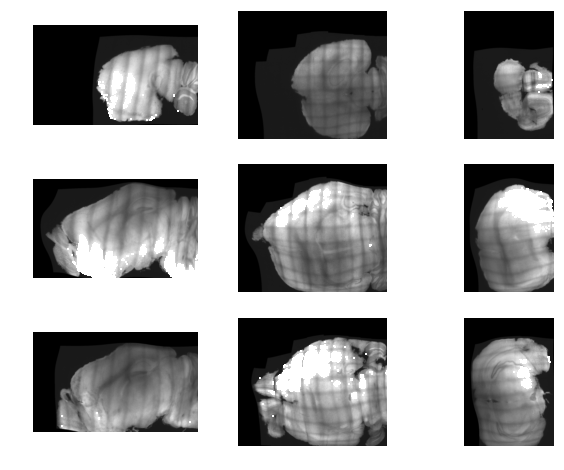

In [38]:
sampleImg_lddmm = imgApplyField(sampleImgReoriented, fieldComposite, size=refImg.GetSize(), spacing=refImg.GetSpacing())
imgShow(sampleImg_lddmm, vmax=sampleThreshold)

### Evaluation LDDMM registration
Now we evaluate the deformable registration using a checkerboard image

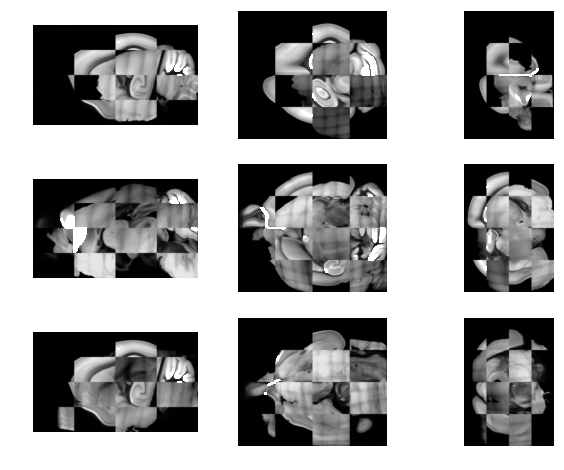

In [39]:
sampleImg_lddmm_ds = imgResample(sampleImg_lddmm, spacing=spacing, size=refImg_ds.GetSize())
imgShow(imgChecker(sampleImg_lddmm, refImg), vmax=refThreshold)

We can also evaluate the registration by overlaying the atlas annotations over the deformed input image.

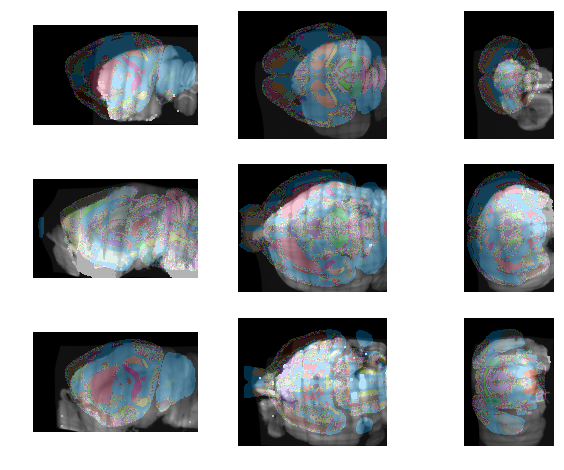

In [40]:
imgShow(sampleImg_lddmm, vmax=sampleThreshold, newFig=False)
imgShow(refAnnotationImg, vmax=1000, cmap=randCmap, alpha=0.3, newFig=False)
plt.show()

# Deform annotation to sample space and upload to Boss

In [149]:
SAMPLE_COLLECTION = 's3617_to_ara_coll'
SAMPLE_EXPERIMENT = 's3617_to_ara_exp'
SAMPLE_CHANNEL = 's3617_to_ara_10um_affine'
NEW_CHANNEL_NAME = 'annotation_ara_s3617_test4'
SAMPLE_RESOLUTION = 0
CHANNEL_TYPE = 'annotation'
DATATYPE = 'uint64'

In [89]:
refAnnotationImg_lddmm = imgApplyField(refAnnotationImg, invFieldComposite, size=sampleImgReoriented.GetSize(), spacing=sampleImgReoriented.GetSpacing(), useNearest=True)

In [90]:
# convert the reference image to the same orientation as the input image
refAnnotationImg_lddmm = imgReorient(refAnnotationImg_lddmm, refOrient, sampleOrient)

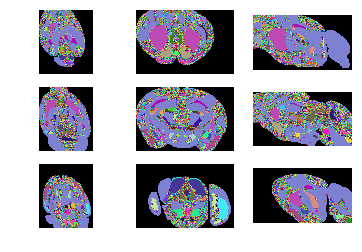

In [91]:
imgShow(refAnnotationImg_lddmm, vmax=1000, cmap=randCmap)

In [150]:
new_channel_resource = ChannelResource(NEW_CHANNEL_NAME, SAMPLE_COLLECTION, SAMPLE_EXPERIMENT, type=CHANNEL_TYPE, 
                                    base_resolution=SAMPLE_RESOLUTION, sources=[SAMPLE_CHANNEL], datatype=DATATYPE)
new_rsc = rmt.create_project(new_channel_resource)
#channel = rmt.get_channel(NEW_CHANNEL_NAME, SAMPLE_COLLECTION, SAMPLE_EXPERIMENT)


In [151]:
new_rsc.cutout_ready

True

In [25]:
import tifffile as tf

In [36]:
data = tf.imread('s3617_to_ara_affine_10um.tif')
data.dtype

dtype('uint16')

In [37]:
data.shape

(1140, 800, 1320)

In [144]:
data = sitk.GetArrayFromImage(refAnnotationImg)

In [145]:
data.shape

(1140, 800, 1320)

In [95]:
size = sampleImg.GetSize()
refAnnotationImg_lddmm_np = sitk.GetArrayFromImage(refAnnotationImg_lddmm)
refAnnotationImg_lddmm_np = refAnnotationImg_lddmm_np.transpose()
refAnnotationImg_lddmm_np = refAnnotationImg_lddmm_np.copy(order='C')

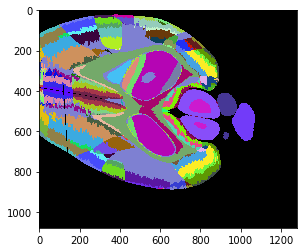

In [96]:
plt.imshow(refAnnotationImg_lddmm_np[:,:,150], vmax=1000, cmap=randCmap)

In [146]:
data.flags['C_CONTIGUOUS']

True

In [152]:
def upload_to_boss(data, channel_resource, resolution=0):
    Z_LOC = 2
    size = data.shape
    for i in range(0, data.shape[Z_LOC], 16):
        last_z = i+16
        if last_z > data.shape[Z_LOC]:
            last_z = data.shape[Z_LOC]
        print(resolution, [i, last_z], [0, size[1]], [0, size[0]])
        rmt.create_cutout(channel_resource, resolution, [i, last_z], [0, size[1]], [0, size[0]], np.asarray(data[:,:,i:last_z], order='C'))

In [153]:
upload_to_boss(data, new_rsc)

(0, [0, 16], [0, 800], [0, 1140])
(0, [16, 32], [0, 800], [0, 1140])
(0, [32, 48], [0, 800], [0, 1140])
(0, [48, 64], [0, 800], [0, 1140])
(0, [64, 80], [0, 800], [0, 1140])


KeyboardInterrupt: 

In [58]:
print(refAnnotationImg_lddmm_np.shape[-1])
for i in range(0, refAnnotationImg_lddmm_np.shape[-1], 16):
    last_z = i+16
    if last_z > refAnnotationImg_lddmm_np.shape[-1]:
        last_z = refAnnotationImg_lddmm_np.shape[-1]
#     tmp_array = np.zeros(refAnnotationImg_lddmm_np[:,:,i:last_z].shape, order='C')
#     tmp_array[:,:,:] = refAnnotationImg_lddmm_np[:,:,i:last_z]
#     tmp_array = np.ascontiguousarray(refAnnotationImg_lddmm_np[:,:,i:last_z])
    tmp_array = refAnnotationImg_lddmm_np[:,:,i:last_z].copy(order='C')
    #print('c contiguous?: ' + str(tmp_array.flags['C_CONTIGUOUS']))
    print(SAMPLE_RESOLUTION, [0, size[0]], [0, size[1]], [i, last_z])
    rmt.create_cutout(new_rsc, SAMPLE_RESOLUTION, [0, size[0]], [0, size[1]], [i, last_z], tmp_array)

356
c contiguous?: True
(0, [0, 540], [0, 640], [0, 16])
c contiguous?: True
(0, [0, 540], [0, 640], [16, 32])
c contiguous?: True
(0, [0, 540], [0, 640], [32, 48])
c contiguous?: True
(0, [0, 540], [0, 640], [48, 64])
c contiguous?: True
(0, [0, 540], [0, 640], [64, 80])
c contiguous?: True
(0, [0, 540], [0, 640], [80, 96])
c contiguous?: True
(0, [0, 540], [0, 640], [96, 112])
c contiguous?: True
(0, [0, 540], [0, 640], [112, 128])
c contiguous?: True
(0, [0, 540], [0, 640], [128, 144])
c contiguous?: True
(0, [0, 540], [0, 640], [144, 160])
c contiguous?: True
(0, [0, 540], [0, 640], [160, 176])
c contiguous?: True
(0, [0, 540], [0, 640], [176, 192])
c contiguous?: True
(0, [0, 540], [0, 640], [192, 208])
c contiguous?: True
(0, [0, 540], [0, 640], [208, 224])
c contiguous?: True
(0, [0, 540], [0, 640], [224, 240])
c contiguous?: True
(0, [0, 540], [0, 640], [240, 256])
c contiguous?: True
(0, [0, 540], [0, 640], [256, 272])
c contiguous?: True
(0, [0, 540], [0, 640], [272, 288])
c 